<a href="https://colab.research.google.com/github/Matteo-Candi/Fine-Tuning-with-LoRA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
!pip install -q datasets

In [ ]:
from transformers import set_seed, BertTokenizer, TFBertModel, TFBertForSequenceClassification, TFBertMainLayer
from datasets import load_dataset, concatenate_datasets
import tensorflow as tf

from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import math

In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

# Dataset and Preprocessing

In [ ]:
dataset = load_dataset("go_emotions", "simplified").shuffle(seed=17)
labels = dataset['train'].features['labels'].feature.names
dataset = dataset.remove_columns('id')


def filter_labels(example):
    return len(example['labels']) < 2

for split in dataset.keys():
    dataset[split] = dataset[split].filter(filter_labels)

model_name = "bert-base-cased"
num_labels = 28

tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
def get_df_summary(df):
    label_column = df['labels'].to_list()
    flatten_col = list(itertools.chain(*label_column))
    freq_dict = dict(Counter(flatten_col))
    freq_list = list(dict(sorted(freq_dict.items())).values())
    rel_freq_list = [el / sum(freq_list) * 100 for el in freq_list]

    return rel_freq_list

In [ ]:
df_train = dataset['train'].to_pandas()
df_val = dataset['validation'].to_pandas()
df_test = dataset['test'].to_pandas()

# Get dataframes info.
train_freq = get_df_summary(df_train)
val_freq = get_df_summary(df_val)
test_freq = get_df_summary(df_test)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.25
index = np.arange(len(train_freq))
bars_train = ax.barh(index, train_freq, bar_width, label='Train')
bars_val = ax.barh(index + bar_width, val_freq, bar_width, label='Validation')
bars_test = ax.barh(index + 2*bar_width, test_freq, bar_width, label='Test')
plt.xlabel('%')
plt.title('Percentage of Feelings')
plt.yticks(index + bar_width, labels)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def tokenizer_func(text):
    '''
    Tokenizing the text using the BERT tokenizer.
    '''
    # Checking there is just one tokenization up to 316 and the second longest one is 120.
    # token_lengths = [sum(tokenized_train[i][0] != 0) for i in range(len(tokenized_train))]
    return tokenizer(text, padding = 'max_length', max_length = 120, return_tensors = "tf", truncation=True)

def one_hot_func(indices):
    '''
    Converting a value in one hot encode vector.
    '''
    one_hot_encoding = np.zeros(28, dtype=int)
    one_hot_encoding[indices] = 1
    return {'labels': one_hot_encoding}

def process_dataset_func(dataset):
    '''
    Processing the dataset to make it readable from the model.
    '''
    processed_dataset = dataset.map(lambda x: tokenizer_func(x['text']))
    processed_dataset = processed_dataset.map(lambda x: one_hot_func(x['labels']))
    processed_dataset = processed_dataset.remove_columns('text')
    return processed_dataset

In [ ]:
dataset = process_dataset_func(dataset)

In [ ]:
batch_size = 32
tf_dataset_train = tf.data.Dataset.from_tensor_slices((dataset['train']['input_ids'], dataset['train']['labels'])).batch(batch_size)
tf_dataset_validation = tf.data.Dataset.from_tensor_slices((dataset['validation']['input_ids'], dataset['validation']['labels'])).batch(batch_size)
tf_dataset_test = tf.data.Dataset.from_tensor_slices((dataset['test']['input_ids'], dataset['test']['labels'])).batch(batch_size)

# Reshape labels to match the model output.
tf_dataset_train = tf_dataset_train.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))
tf_dataset_validation = tf_dataset_validation.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))
tf_dataset_test = tf_dataset_test.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))

# Models

## Base model

In [ ]:
pretrained_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = num_labels)
pretrained_model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_242 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  21532     
                                                                 
Total params: 108331804 (413.25 MB)
Trainable params: 108331804 (413.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
class BaseModel(tf.keras.Model):
    def __init__(self, model_name, num_labels):
        super(BaseModel, self).__init__()
        self.num_labels = num_labels

        # When importing the model some weigths have different initialization states.
        set_seed(17)
        self.model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = self.num_labels)
        self.softmax = tf.keras.layers.Activation('softmax')


    def call(self, input):

        # The model detect automatically 'input_ids' and 'attention_mask'.
        logits = self.model(input)[0]
        model_output = self.softmax(logits)


        return model_output

In [ ]:
stop

In [ ]:
base_model = BaseModel(model_name, num_labels)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_function = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

base_model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

num_epochs = 5

base_model_history = base_model.fit(tf_dataset_train, validation_data=tf_dataset_validation, epochs=num_epochs, batch_size=batch_size)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
1135/1135 [==============================] - 978s 806ms/step - loss: 1.6934 - accuracy: 0.5419 - val_loss: 1.3562 - val_accuracy: 0.6102
Epoch 2/5
1135/1135 [==============================] - 913s 804ms/step - loss: 1.0871 - accuracy: 0.6727 - val_loss: 1.3531 - val_accuracy: 0.6025
Epoch 3/5
1135/1135 [==============================] - 914s 805ms/step - loss: 0.6283 - accuracy: 0.8094 - val_loss: 1.6252 - val_accuracy: 0.5772
Epoch 4/5
1135/1135 [==============================] - 895s 789ms/step - loss: 0.3395 - accuracy: 0.8971 - val_loss: 1.8789 - val_accuracy: 0.5851
Epoch 5/5
1135/1135 [==============================] - 892s 786ms/step - loss: 0.1989 - accuracy: 0.9394 - val_loss: 2.1411 - val_accuracy: 0.5772


In [ ]:
base_model_history.history

# {'loss': [1.6934291124343872,
#   1.0871013402938843,
#   0.6282956004142761,
#   0.3395499289035797,
#   0.19886009395122528],
#  'accuracy': [0.5418640375137329,
#   0.6727442741394043,
#   0.809380829334259,
#   0.8971301317214966,
#   0.939434826374054],
#  'val_loss': [1.3562015295028687,
#   1.3530546426773071,
#   1.6251964569091797,
#   1.878911018371582,
#   2.1410646438598633],
#  'val_accuracy': [0.6101583242416382,
#   0.602462649345398,
#   0.5771768093109131,
#   0.5850923657417297,
#   0.5771768093109131]}

{'loss': [1.6934291124343872,
  1.0871013402938843,
  0.6282956004142761,
  0.3395499289035797,
  0.19886009395122528],
 'accuracy': [0.5418640375137329,
  0.6727442741394043,
  0.809380829334259,
  0.8971301317214966,
  0.939434826374054],
 'val_loss': [1.3562015295028687,
  1.3530546426773071,
  1.6251964569091797,
  1.878911018371582,
  2.1410646438598633],
 'val_accuracy': [0.6101583242416382,
  0.602462649345398,
  0.5771768093109131,
  0.5850923657417297,
  0.5771768093109131]}

In [ ]:
data ={'loss': [1.6934291124343872,
  1.0871013402938843,
  0.6282956004142761,
  0.3395499289035797,
  0.19886009395122528],
 'accuracy': [0.5418640375137329,
  0.6727442741394043,
  0.809380829334259,
  0.8971301317214966,
  0.939434826374054],
 'val_loss': [1.3562015295028687,
  1.3530546426773071,
  1.6251964569091797,
  1.878911018371582,
  2.1410646438598633],
 'val_accuracy': [0.6101583242416382,
  0.602462649345398,
  0.5771768093109131,
  0.5850923657417297,
  0.5771768093109131]}

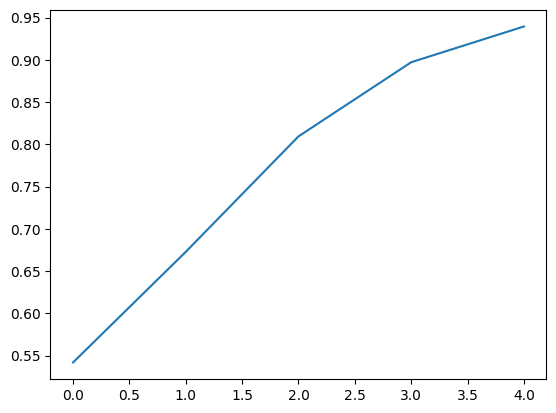

In [ ]:
plt.plot(data['accuracy'])

In [ ]:
output = base_model.evaluate(tf_dataset_test)
accuracy_on_test_set = output[1]
round(accuracy_on_test_set, 4)

0.5863

## Model fine-tuned with LoRA

In [ ]:
class LoraLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        rank=8,
        alpha=32,
        **kwargs):

        super().__init__(**kwargs)
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]

        self.rank = rank
        self.alpha = alpha

        self._scale = alpha / rank

        self._hidden_dim = original_layer_config['units']

        self.original_layer = tf.keras.layers.Dense(self._hidden_dim, name=f'lora_{name}')
        self.original_layer.build(self._hidden_dim)
        self.original_layer.set_weights(original_layer.get_weights())


        # LoRA dense layers.
        self.A = tf.keras.layers.Dense(
            units=rank,
            use_bias=False,
            # Note: the original paper mentions that normal distribution was
            # used for initialization. However, the official LoRA implementation
            # uses "Kaiming/He Initialization".
            kernel_initializer=tf.keras.initializers.VarianceScaling(
                scale=math.sqrt(5), mode="fan_in", distribution="uniform", seed=17
            ),
            name="lora_A",
        )

        self.B = tf.keras.layers.EinsumDense(
            equation='abc,cd->abd',
            output_shape=(120, 768),
            kernel_initializer="zeros",
            name="lora_B",
        )


    def call(self, inputs):
        original_output = self.original_layer(inputs)
            # If we are fine-tuning the model, we will add LoRA layers' output
            # to the original layer's output.
        A_output = self.A(inputs)
        B_output = self.B(A_output)
        lora_output = B_output * self._scale

        return lora_output + original_output



class LoraModel(tf.keras.Model):
    def __init__(self, model_name, num_labels, rank, alpha, model):
        super(LoraModel, self).__init__()

        # When importing the model some weigths have different initialization states.
        # self.model = model
        set_seed(17)
        self.model = model
        # for layer in self.model.bert._flatten_layers():
        #     layer.trainable = False

        # self.add_lora_layers_to_bert(rank, alpha)
        # self.model.bert.trainable = False

        self.softmax = tf.keras.layers.Activation('softmax')


    def add_lora_layers_to_bert(self, rank=8, alpha=32):

        for i in range(12):

            self.model.bert.encoder.layer[i].attention.self_attention.query = LoraLayer(
                self.model.bert.encoder.layer[i].attention.self_attention.query,
                rank=rank,
                alpha=alpha)

            self.model.bert.encoder.layer[i].attention.self_attention.key = LoraLayer(
                self.model.bert.encoder.layer[i].attention.self_attention.key,
                rank=rank,
                alpha=alpha)

            self.model.bert.encoder.layer[i].attention.self_attention.value = LoraLayer(
                    self.model.bert.encoder.layer[i].attention.self_attention.value,
                    rank=rank,
                    alpha=alpha)



    def call(self, input):

        # The model detect automatically 'input_ids' and 'attention_mask'.
        logits = self.model(input)[0]
        model_output = self.softmax(logits)

        return model_output

In [ ]:
def add_lora_layers_to_bert(rank=8, alpha=32):
    for i in range(12):

        model.bert.encoder.layer[i].attention.self_attention.query = LoraLayer(
            model.bert.encoder.layer[i].attention.self_attention.query,
            rank=rank,
            alpha=alpha)

        model.bert.encoder.layer[i].attention.self_attention.key = LoraLayer(
            model.bert.encoder.layer[i].attention.self_attention.key,
            rank=rank,
            alpha=alpha)

        model.bert.encoder.layer[i].attention.self_attention.value = LoraLayer(
                model.bert.encoder.layer[i].attention.self_attention.value,
                rank=rank,
                alpha=alpha)

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 28)
add_lora_layers_to_bert(8, 16)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for layer in list(model._flatten_modules()):
    if len(list(layer._flatten_modules())) == 1:
        if layer.name not in ['lora_A', 'lora_B', 'classifier']:
            layer.trainable = False

In [ ]:
model.bert.encoder.layer[i].intermediate

In [ ]:
model.bert.embeddings.LayerNorm.trainable = False
model.bert.pooler.dense.trainable = False

for i in range(len(model.bert.encoder.layer)):
    layer = model.bert.encoder.layer[i]

    layer.bert_output.LayerNorm.trainable = False
    layer.bert_output.dense.trainable = False

    layer.intermediate.dense.trainable = False

    layer.attention.dense_output.dense.trainable = False
    layer.attention.dense_output.LayerNorm.trainable = False

    layer.attention.self_attention.query.original_layer.trainable = False
    layer.attention.self_attention.key.original_layer.trainable = False
    layer.attention.self_attention.value.original_layer.trainable = False

In [ ]:
first_element = next(iter(tf_dataset_train))[0]
_ = model(first_element)
model.summary()

Model: "tf_bert_for_sequence_classification_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108752640 
                                                                 
 dropout_2849 (Dropout)      multiple                  0         
                                                                 
 classifier (Dense)          multiple                  21532     
                                                                 
Total params: 108774172 (414.94 MB)
Trainable params: 23127580 (88.22 MB)
Non-trainable params: 85646592 (326.72 MB)
_________________________________________________________________


In [ ]:
(23127580 - 463900) / 12

3.1978760294755095

In [ ]:
108774172 - 108331804

442368

In [ ]:
# Parameteres for LoRA.
rank = 8
alpha = 16

# Create the model.
lora_model = LoraModel(model_name, num_labels, rank, alpha, model)

# Build the model passing a sample through it.
first_element = next(iter(tf_dataset_train))[0]
_ = lora_model(first_element)

Let's start considering that we want to implement LoRA layers in all the matrices if the self attention (#3) for all the heads of bert-base (#12).

The total number of Query, Key and Value matrices' parameters is $21261312$,

$21261312 / 12 = 1771776$ parameters for each head,

$1771776 / 3 = 590592 = 768 \times 768 + 768$ parameters for each matrix.


The total number of new parameters add with LoRA are $(768 \times rank + rank \times 768) \times 3 \times 12 = 442368$.

So, considering also the classifier's parameters, the total amount of trainable parameters is $442368 + 21532 = 463900$.

In [ ]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-4)
loss_function = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

lora_model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

num_epochs = 1

lora_model_history = lora_model.fit(tf_dataset_train, validation_data=tf_dataset_validation, epochs=num_epochs, batch_size=batch_size)

  14/1135 [..............................] - ETA: 14:53 - loss: 2.8617 - accuracy: 0.3103

KeyboardInterrupt: 

In [ ]:
lora_model.model.classifier.get_weights()[0]

array([[-0.00591019, -0.00484577,  0.01100573, ..., -0.00311598,
        -0.02416917,  0.00409354],
       [-0.02039267,  0.00942053,  0.0025434 , ...,  0.00891148,
         0.0012288 ,  0.00054411],
       [ 0.00893728, -0.02101945, -0.00922329, ...,  0.007544  ,
         0.00898259,  0.03755317],
       ...,
       [-0.00194424,  0.00653094, -0.0041351 , ..., -0.01534467,
        -0.02725969,  0.01637444],
       [ 0.01192218,  0.00274544, -0.01700132, ..., -0.00941994,
        -0.02123295,  0.01323891],
       [ 0.00884701, -0.00757739,  0.00854274, ...,  0.00947676,
        -0.01690845,  0.02813397]], dtype=float32)

In [ ]:
lora_model.model.bert.encoder.layer[11].attention.self_attention.key.A.get_weights()

[array([[ 0.0884343 , -0.07185138,  0.05943378, ..., -0.08395838,
          0.02477893,  0.02181597],
        [-0.00091249, -0.08824681,  0.06573258, ..., -0.06960507,
         -0.08878529,  0.05152037],
        [-0.06314621, -0.0055666 , -0.05208993, ..., -0.08678542,
          0.01738612, -0.05438538],
        ...,
        [ 0.0630657 , -0.0043783 , -0.01258984, ..., -0.08278234,
         -0.02204023, -0.06064276],
        [ 0.04710453,  0.01308293,  0.0593427 , ..., -0.04989512,
         -0.00659908,  0.07868818],
        [ 0.0525265 ,  0.00650924,  0.01982998, ..., -0.00834987,
          0.07899635,  0.01037245]], dtype=float32)]

In [ ]:
lora_model.model.bert.encoder.layer[0].attention.self_attention.key.original_layer.get_weights()[0]

array([[ 2.8657176e-02,  4.8005264e-03,  4.9075916e-02, ...,
        -8.8107968e-03,  5.6885206e-03,  5.4868605e-02],
       [-3.0682154e-02, -3.0306482e-03, -1.2872593e-02, ...,
        -3.2314227e-03,  5.2937653e-02, -3.6515070e-03],
       [-2.6920761e-03,  2.4164479e-02, -1.3647523e-02, ...,
         1.1721017e-02,  9.4898082e-03,  1.5124909e-02],
       ...,
       [ 2.3737766e-02,  7.4703549e-03,  3.8690038e-02, ...,
        -2.8807104e-02,  5.6113109e-02, -2.0291412e-02],
       [-7.9208333e-03,  4.4420104e-02,  1.6604092e-02, ...,
         4.6373899e-03,  2.6797490e-02, -2.8913473e-03],
       [-1.0335554e-02,  2.5628829e-02,  7.9800091e-05, ...,
         3.5981752e-02,  4.9961805e-02,  1.4802449e-02]], dtype=float32)

In [ ]:
lora_model_history.history

Sources:
- [Multi class with Bert](https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi-Class%20classification%20TF-BERT/multi_class.ipynb)

- [Dataset Preprocessing](https://huggingface.co/docs/datasets/v1.12.1/use_dataset.html)

- [Bert model layers comprehension](https://github.com/huggingface/transformers/blob/ef609958586a24b7943ad6c31184ff5a84b6f8e2/src/transformers/models/bert/modeling_tf_bert.py#L369)

- [LoRA Layer and injection](https://github.com/keras-team/keras-io/blob/master/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora.py)

- [LoRA parameters](https://arxiv.org/abs/2106.09685)